In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import gc



In [2]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv')
print(train.shape)
print(test.shape)

sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
print(sub.shape)
labels = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
print('label', labels.shape)

(1558080, 16)
(733080, 16)
(12218, 2)
label (25968, 2)


In [3]:
features = [c for c in train.columns if 'sensor' in c]

# adding labels to train data
train = pd.merge(train, labels,how='left', on="sequence")
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


# FE

In [4]:
def addFeatures(df):  
    
    for f in features:
        df[f + '_lag1'] = df.groupby('sequence')[f].shift(1).fillna(0).astype('float32')
        
        #df[f + '_lag_back1'] = df.groupby('sequence')[f].shift(-1).fillna(0).astype('float32')
        #df[f + '_cumsum'] = df.groupby('sequence')[f].cumsum().astype('float32')
        df[f + '_diff1'] = (df[f] - df[f + '_lag1']).astype('float32')
    return df

train = addFeatures(train)
test = addFeatures(test)

print(train.shape)
print(test.shape)
train.head()

(1558080, 43)
(733080, 42)


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_08_lag1,sensor_08_diff1,sensor_09_lag1,sensor_09_diff1,sensor_10_lag1,sensor_10_diff1,sensor_11_lag1,sensor_11_diff1,sensor_12_lag1,sensor_12_diff1
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,...,0.0,-0.1,0.000000,-0.963873,0.000000,-0.985069,0.000000,0.531893,0.000000,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,...,-0.1,0.3,-0.963873,0.662572,-0.985069,1.067802,0.531893,-0.763375,4.751492,-4.297101
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,...,0.2,1.2,-0.301301,1.303468,0.082733,0.366488,-0.231481,-0.354938,0.454390,-5.190537
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,...,1.4,-1.7,1.002168,-1.997832,0.449221,-0.883511,-0.586420,1.931070,-4.736146,5.165388
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,...,-0.3,-0.6,-0.995665,2.051301,-0.434290,1.246921,1.344650,-1.221193,0.429241,-0.652600


In [5]:
Window = 60

target = train.state.values

y = train['state'].to_numpy().reshape(-1, Window)
train.drop(["sequence","step","subject","state"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler
sc = StandardScaler()

train = sc.fit_transform(train)
test = sc.transform(test)

In [7]:
train = train.reshape(-1, Window, train.shape[-1])
test = test.reshape(-1, Window, train.shape[-1])
print(train.shape)

(25968, 60, 39)


In [8]:
import tensorflow as tf
import logging
from tensorflow.keras import *

2022-04-05 00:06:17.153992: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-05 00:06:17.154115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1


2022-04-05 00:06:23.210327: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-05 00:06:23.213964: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-05 00:06:23.214009: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-05 00:06:23.214037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b0319a000ab5): /proc/driver/nvidia/version does not exist
2022-04-05 00:06:23.218241: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


# LSTM

In [10]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [11]:
from tensorflow.keras.metrics import AUC

def createModel():
    with strategy.scope():
        model = Sequential(
        [
            Input(shape = (Window, train.shape[-1])),
            Bidirectional(LSTM(768, return_sequences = True)),
            Bidirectional(LSTM(512, return_sequences = True)), 
            Bidirectional(LSTM(256, return_sequences = True)),
            Bidirectional(LSTM(128, return_sequences = True)),
            Dense(128, activation = 'selu'),
            Dense(1, activation = 'sigmoid')
        ]
        )
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [AUC(name = 'auc')]
                     )
    return (model)

fold 1
****************************************


2022-04-05 00:06:47.462247: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 194444640 exceeds 10% of free system memory.


Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.6758 - auc: 0.6231

2022-04-05 00:07:27.574180: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 48615840 exceeds 10% of free system memory.


82/82 [==============================] - 44s 264ms/step - loss: 0.6753 - auc: 0.6240 - val_loss: 0.5536 - val_auc: 0.8129
Epoch 2/50
82/82 [==============================] - 6s 76ms/step - loss: 0.5094 - auc: 0.8268 - val_loss: 0.4299 - val_auc: 0.8835
Epoch 3/50
82/82 [==============================] - 6s 77ms/step - loss: 0.4021 - auc: 0.8982 - val_loss: 0.3784 - val_auc: 0.9141
Epoch 4/50
82/82 [==============================] - 6s 77ms/step - loss: 0.3568 - auc: 0.9215 - val_loss: 0.3368 - val_auc: 0.9325
Epoch 5/50
82/82 [==============================] - 6s 77ms/step - loss: 0.2972 - auc: 0.9461 - val_loss: 0.3601 - val_auc: 0.9309

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 6/50
82/82 [==============================] - 6s 77ms/step - loss: 0.2621 - auc: 0.9580 - val_loss: 0.2946 - val_auc: 0.9509
Epoch 7/50
82/82 [==============================] - 6s 77ms/step - loss: 0.2360 - auc: 0.9659 - val_loss: 0.2766 - val_auc: 0.9541
Epoch 8/50
8

2022-04-05 00:09:11.961067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114360480 exceeds 10% of free system memory.


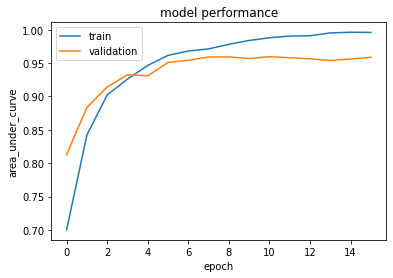

fold 2
****************************************


2022-04-05 00:09:24.915969: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 194444640 exceeds 10% of free system memory.


Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.6735 - auc: 0.6113

2022-04-05 00:10:04.912460: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 48615840 exceeds 10% of free system memory.


82/82 [==============================] - 44s 256ms/step - loss: 0.6730 - auc: 0.6123 - val_loss: 0.5879 - val_auc: 0.8048
Epoch 2/50
82/82 [==============================] - 6s 77ms/step - loss: 0.5434 - auc: 0.8002 - val_loss: 0.4284 - val_auc: 0.8874
Epoch 3/50
82/82 [==============================] - 6s 77ms/step - loss: 0.4231 - auc: 0.8864 - val_loss: 0.3985 - val_auc: 0.9108
Epoch 4/50
82/82 [==============================] - 6s 77ms/step - loss: 0.3515 - auc: 0.9243 - val_loss: 0.3481 - val_auc: 0.9290
Epoch 5/50
82/82 [==============================] - 6s 77ms/step - loss: 0.3144 - auc: 0.9394 - val_loss: 0.3099 - val_auc: 0.9432

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 6/50
82/82 [==============================] - 6s 77ms/step - loss: 0.2581 - auc: 0.9595 - val_loss: 0.2685 - val_auc: 0.9571
Epoch 7/50
82/82 [==============================] - 6s 76ms/step - loss: 0.2206 - auc: 0.9702 - val_loss: 0.2730 - val_auc: 0.9568
Epoch 8/50
8

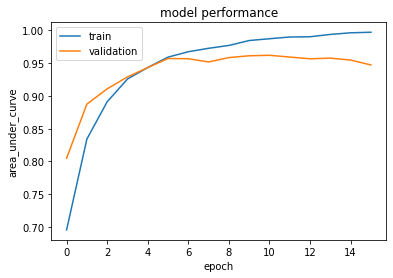

fold 3
****************************************
Epoch 1/50
82/82 [==============================] - 44s 254ms/step - loss: 0.6677 - auc: 0.6275 - val_loss: 0.5772 - val_auc: 0.7959
Epoch 2/50
82/82 [==============================] - 6s 76ms/step - loss: 0.5242 - auc: 0.8151 - val_loss: 0.4510 - val_auc: 0.8738
Epoch 3/50
82/82 [==============================] - 6s 76ms/step - loss: 0.4230 - auc: 0.8867 - val_loss: 0.4068 - val_auc: 0.9107
Epoch 4/50
82/82 [==============================] - 6s 76ms/step - loss: 0.3693 - auc: 0.9159 - val_loss: 0.3533 - val_auc: 0.9260
Epoch 5/50
82/82 [==============================] - 6s 77ms/step - loss: 0.3104 - auc: 0.9411 - val_loss: 0.3269 - val_auc: 0.9410

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 6/50
82/82 [==============================] - 6s 77ms/step - loss: 0.2568 - auc: 0.9600 - val_loss: 0.2955 - val_auc: 0.9545
Epoch 7/50
82/82 [==============================] - 6s 76ms/step - loss: 0.2255 - au

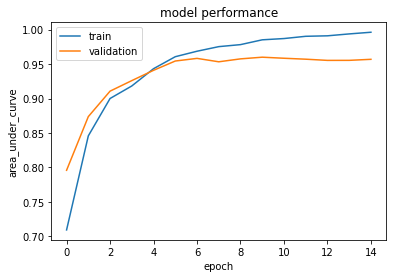

fold 4
****************************************
Epoch 1/50
82/82 [==============================] - 44s 259ms/step - loss: 0.6731 - auc: 0.6250 - val_loss: 0.5366 - val_auc: 0.8161
Epoch 2/50
82/82 [==============================] - 6s 76ms/step - loss: 0.5007 - auc: 0.8323 - val_loss: 0.4273 - val_auc: 0.8974
Epoch 3/50
82/82 [==============================] - 6s 77ms/step - loss: 0.3963 - auc: 0.9014 - val_loss: 0.3695 - val_auc: 0.9191
Epoch 4/50
82/82 [==============================] - 6s 77ms/step - loss: 0.3608 - auc: 0.9191 - val_loss: 0.3431 - val_auc: 0.9342
Epoch 5/50
82/82 [==============================] - 6s 76ms/step - loss: 0.3095 - auc: 0.9415 - val_loss: 0.2835 - val_auc: 0.9514

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 6/50
82/82 [==============================] - 6s 76ms/step - loss: 0.2591 - auc: 0.9591 - val_loss: 0.3327 - val_auc: 0.9548
Epoch 7/50
82/82 [==============================] - 6s 76ms/step - loss: 0.2244 - au

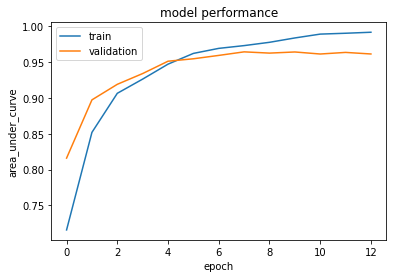

fold 5
****************************************
Epoch 1/50
82/82 [==============================] - 45s 264ms/step - loss: 0.6705 - auc: 0.6177 - val_loss: 0.5216 - val_auc: 0.8151
Epoch 2/50
82/82 [==============================] - 6s 77ms/step - loss: 0.4907 - auc: 0.8381 - val_loss: 0.4959 - val_auc: 0.8755
Epoch 3/50
82/82 [==============================] - 6s 77ms/step - loss: 0.4188 - auc: 0.8886 - val_loss: 0.4214 - val_auc: 0.9064
Epoch 4/50
82/82 [==============================] - 6s 76ms/step - loss: 0.3526 - auc: 0.9239 - val_loss: 0.3479 - val_auc: 0.9345
Epoch 5/50
82/82 [==============================] - 6s 76ms/step - loss: 0.3033 - auc: 0.9440 - val_loss: 0.3276 - val_auc: 0.9386

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 6/50
82/82 [==============================] - 6s 77ms/step - loss: 0.2504 - auc: 0.9619 - val_loss: 0.2827 - val_auc: 0.9515
Epoch 7/50
82/82 [==============================] - 6s 76ms/step - loss: 0.2204 - au

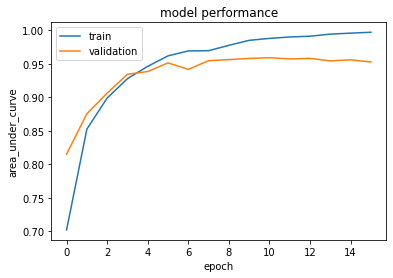

CPU times: user 3min 36s, sys: 32.4 s, total: 4min 8s
Wall time: 12min 51s


In [12]:
%%time

from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *

skf = KFold(n_splits = 5, shuffle = True, random_state = 2022)
preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train, y)):
    print('fold', fold+1)
    print('*'*40)
    
    X_train, X_valid = train[train_idx], train[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]
    
    es = EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 5, verbose = 1, restore_best_weights = True)
    lr = ReduceLROnPlateau(monitor="val_auc", factor=0.8, 
                               patience=4, verbose = 1)
    model = createModel()
    
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                       epochs = 50, batch_size = 256, callbacks = [es, lr])
    
    preds.append(model.predict(test).squeeze())
    plotHist(history)
    
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect()
    

# Submission

In [13]:
sub["state"] = sum(preds)/skf.n_splits 
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,0.993004
1,25969,0.989543
2,25970,0.017511
3,25971,0.743935
4,25972,0.599216
...,...,...
12213,38181,0.444352
12214,38182,0.828131
12215,38183,0.296169
12216,38184,0.061713
